# Notes: 
    
Contextual bandit

Reward is yards gained + touchdown + first down

Arms will be the play types 

Context will be set of features

Will need some sort of randomization component to not exploit plays 

need to find best play for each context

Evaluate against replay

Find real time plays that match prediction 

See how many are successful 

Success is within sd of yards gained, touchdown, first down

In [1]:
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Download and prep Data

In [2]:
#download data
!aws s3 cp s3://capstone-nfl-data/NFL_PBP_Data_2010_2022_original.parquet NFL_PBP_Data_2010_2022_original.parquet

download: s3://capstone-nfl-data/NFL_PBP_Data_2010_2022_original.parquet to ./NFL_PBP_Data_2010_2022_original.parquet


In [3]:
#Load Data
df = pd.read_parquet('NFL_PBP_Data_2010_2022_original.parquet', engine='pyarrow')
df.head()
print(df.shape)

(588078, 384)


In [4]:
df = df[df['play_type'].isin(['pass', 'run', 'punt', 'extra_point', 'field_goal']) ]
df = df[~(df['game_half'] == 'Overtime' )]

In [5]:
df = df[df['season'] >= 2016]
print(df.shape)

(234806, 384)


In [6]:
def transform_off_personnel(row):

   rb_count = 0
   te_count = 0
   wr_count = 0
   ol_count = 0
   dl_count = 0
   db_count = 0

   if not pd.isna(row['offense_personnel']):
       personnel = row['offense_personnel'].split(', ')
       for p in personnel:
           if p[2:4] == 'RB':
               rb_count = int(p[0])
           elif p[2:4] == 'TE':
                te_count = int(p[0])
           elif p[2:4] == 'WR':
                wr_count = int(p[0])
           elif p[2:4] == 'OL':
                ol_count = int(p[0])
           elif p[2:4] == 'DL':
                dl_count = int(p[0])
           elif p[2:4] == 'DB':
               db_count = int(p[0])
       
   formation = str(rb_count) + str(te_count)
   return pd.Series([rb_count,te_count,wr_count,ol_count,dl_count, db_count, formation])

df[['off_rb_count','off_te_count','off_wr_count','off_ol_count','off_dl_count', 'off_db_count', 'formation']] = df.apply(transform_off_personnel, axis=1)

In [7]:
def transform_def_personnel(row):

   dl_count = 0
   db_count = 0
   lb_count = 0
   rb_count = 0
   wr_count = 0
   ol_count = 0
   
   if not pd.isna(row['defense_personnel']):
       personnel = row['defense_personnel'].split(', ')
       for p in personnel:
           if p[2:4] == 'LB':
                lb_count = int(p[0])
           elif p[2:4] == 'DL':
                dl_count = int(p[0])
           elif p[2:4] == 'DB':
                db_count = int(p[0])
           elif p[2:4] == 'WR':
                wr_count = int(p[0])
           elif p[2:4] == 'RB':
                rb_count = int(p[0])
           elif p[2:4] == 'OL':
                ol_count = int(p[0])
                
   return pd.Series([dl_count,db_count,lb_count,rb_count,wr_count,ol_count])

df[['def_dl_count','def_db_count','def_lb_count','def_rb_count','def_wr_count','def_ol_count']] = df.apply(transform_def_personnel, axis=1)

In [8]:
# def PlayType_normalized(s):
#   if s['play_type_nfl'] == 'PASS' and s['pass_location'] != None and s['pass_length'] != None: 
#     return 'PASS' + '_' + str(s['pass_location']).upper() + '_' + str(s['pass_length']).upper()
#   elif s['play_type_nfl'] == 'RUSH' and s['run_location'] != None: 
#     return 'RUSH' + '_' + str(s['run_location']).upper()
#   else:
#     return 'OTHER'
# df['PlayType_normalized'] = df.apply(PlayType_normalized, axis=1)

In [9]:
# df = df[~(df['PlayType_normalized'] == 'OTHER' )]

In [10]:
bins = [0,10,20,30,40,50,60,70,80,90,100]
df['yardline_binned'] = pd.cut(df['yardline_100'], bins)

In [11]:
def Play_type_detailed(s):
    if s['play_type'] == 'pass' and s['pass_location'] != None and s['pass_length'] != None: 
        return 'PASS' + '_' + str(s['pass_location']).upper() + '_' + str(s['pass_length']).upper()
    elif s['play_type'] == 'run' and s['run_location'] == 'middle': 
        return 'RUSH' + '_' + str(s['run_location']).upper()
    elif s['play_type'] == 'run' and s['run_location'] != None and s['run_gap'] != None: 
        return 'RUSH' + '_' + str(s['run_location']).upper()+ '_' + str(s['run_gap']).upper()
    else:
        return 'OTHER'

df['Play_type_detailed'] = df.apply(Play_type_detailed, axis=1)
df = df[~(df['Play_type_detailed'] == 'OTHER')]

# Light EDA

In [12]:
print(df.shape)

(197687, 399)


(array([45558.,     0.,     0., 53425.,     0.,     0., 45740.,     0.,
            0., 52964.]),
 array([1.        , 1.29999995, 1.60000002, 1.89999998, 2.20000005,
        2.5       , 2.79999995, 3.0999999 , 3.4000001 , 3.70000005,
        4.        ]),
 <BarContainer object of 10 artists>)

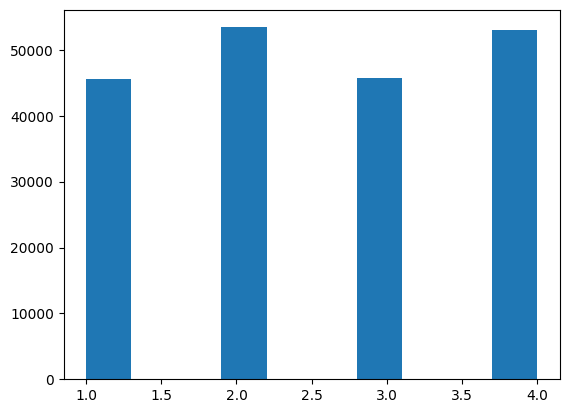

In [13]:
plt.hist(df[['qtr']])

(array([89040.,     0.,     0., 66231.,     0.,     0., 38856.,     0.,
            0.,  3560.]),
 array([1.        , 1.29999995, 1.60000002, 1.89999998, 2.20000005,
        2.5       , 2.79999995, 3.0999999 , 3.4000001 , 3.70000005,
        4.        ]),
 <BarContainer object of 10 artists>)

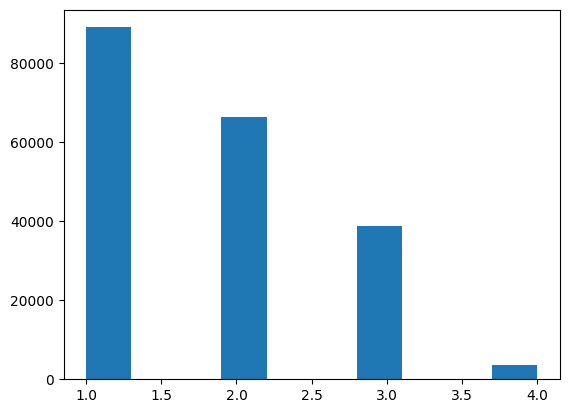

In [14]:
plt.hist(df[['down']])

(array([4.40860e+04, 3.48640e+04, 1.06007e+05, 7.90400e+03, 3.71300e+03,
        7.68000e+02, 2.66000e+02, 5.90000e+01, 7.00000e+00, 1.30000e+01]),
 array([ 1.        ,  5.30000019,  9.60000038, 13.89999962, 18.20000076,
        22.5       , 26.79999924, 31.10000038, 35.40000153, 39.70000076,
        44.        ]),
 <BarContainer object of 10 artists>)

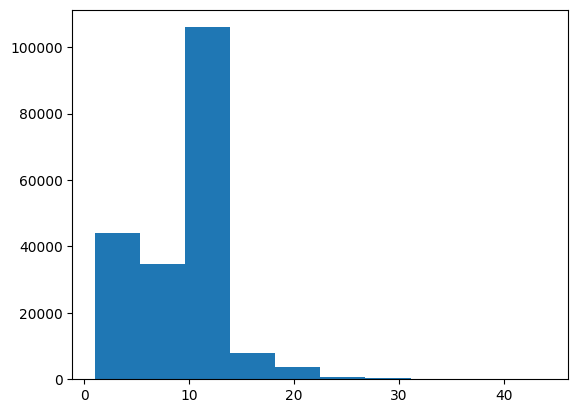

In [15]:
plt.hist(df[['ydstogo']])

In [16]:
context_qtr = df.qtr.unique()
context_down = df.down.unique()
context_yds = ['long', '10', '5', '1']
plays = ['PASS', 'RUSH'] 

print(context_qtr)
print(context_down)
print(context_yds)

[1. 2. 3. 4.]
[1. 2. 3. 4.]
['long', '10', '5', '1']


(array([168618.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  29069.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

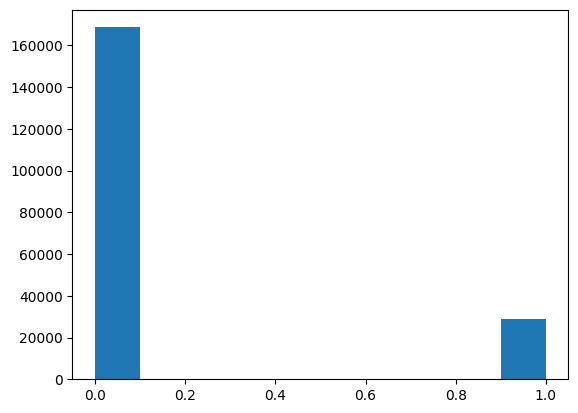

In [17]:
def red_zone(row): 
    if row.yardline_100 <= 20: 
        return 1
    else: 
        return 0

df['red_zone'] = df.apply(red_zone, axis=1)
plt.hist(df.red_zone)

(array([133028.,      0.,      0.,  36151.,      0.,      0.,  20573.,
             0.,      0.,   7935.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

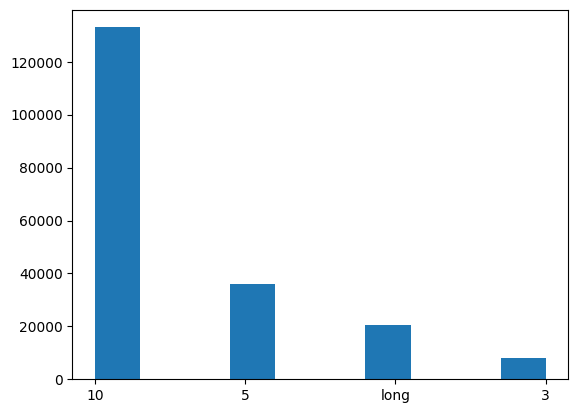

In [18]:
def ydstogo_binning(row): 
    if not row.red_zone: 
        if row.ydstogo > 10: 
            return 'long'
        elif row.ydstogo > 5: 
            return '10'
        else:
            return '5'
    
    if row.red_zone:
        if row.ydstogo > 10: 
            return 'long'
        elif row.ydstogo > 5:
            return '10'
        elif row.ydstogo > 3:
            return '5'
        else:
            return '3'
        
df['ydstogo_binned'] = df.apply(ydstogo_binning, axis=1)
plt.hist(df[['ydstogo_binned']])

(array([45704.,     0., 30526.,     0.,     0., 36513.,     0., 25475.,
            0., 30435.]),
 array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ]),
 <BarContainer object of 10 artists>)

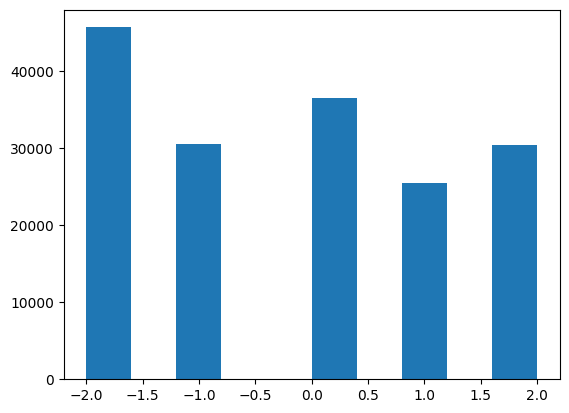

In [19]:
def score_diff_possession(row): 
    diff = row.score_differential
    if diff > 7: 
        return 2
    elif diff > 0 and diff < 7: 
        return 1
    elif diff == 0: 
        return 0
    elif diff < 0 and diff > -7: 
        return -1
    elif diff < -7: 
        return -2
    else:
        return None

df['poss_differential'] = df.apply(score_diff_possession, axis=1)
plt.hist(df.poss_differential)

In [20]:
df[['yards_gained']].describe()

,yards_gained
count,197687.000000
mean,6.058987
std,8.549918
min,-26.000000
25%,0.000000
50%,4.000000
75%,9.000000
max,99.000000


In [21]:
df[['touchdown']].describe()

,touchdown
count,197687.000000
mean,0.042512
std,0.201754
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [22]:
df[['first_down']].describe()

,first_down
count,197687.000000
mean,0.312034
std,0.463325
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


(array([5.52370e+04, 1.24622e+05, 8.95400e+03, 5.55600e+03, 2.18100e+03,
        8.85000e+02, 1.94000e+02, 5.20000e+01, 2.00000e+00, 4.00000e+00]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

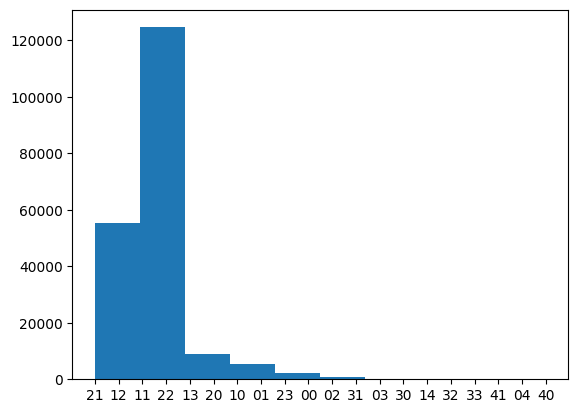

In [23]:
df[['formation']].describe()
plt.hist(df.formation)

In [24]:
df[['yards_gained', 'touchdown', 'first_down']].where(df.formation=='21').dropna().describe()

,yards_gained,touchdown,first_down
count,15995.000000,15995.000000,15995.000000
mean,5.883589,0.031822,0.292591
std,8.559493,0.175533,0.454967
min,-12.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000
75%,8.000000,0.000000,1.000000
max,83.000000,1.000000,1.000000


In [25]:
df[['yards_gained', 'touchdown', 'first_down']].where(df.formation=='12').dropna().describe()

,yards_gained,touchdown,first_down
count,39242.000000,39242.000000,39242.000000
mean,5.750624,0.037460,0.288925
std,8.443411,0.189888,0.453269
min,-12.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000
75%,8.000000,0.000000,1.000000
max,97.000000,1.000000,1.000000


In [26]:
df[['yards_gained', 'touchdown', 'first_down']].where(df.formation=='11').dropna().describe()

,yards_gained,touchdown,first_down
count,118927.000000,118927.000000,118927.000000
mean,6.325124,0.040798,0.321323
std,8.648811,0.197823,0.466987
min,-23.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000
75%,9.000000,0.000000,1.000000
max,98.000000,1.000000,1.000000


In [27]:
df[['yards_gained', 'touchdown', 'first_down']].where(df.formation=='22').dropna().describe()

,yards_gained,touchdown,first_down
count,5695.000000,5695.000000,5695.000000
mean,4.537840,0.096225,0.329061
std,7.469239,0.294925,0.469913
min,-11.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000
75%,6.000000,0.000000,1.000000
max,90.000000,1.000000,1.000000


In [28]:
df[['yards_gained', 'touchdown', 'first_down']].where(df.formation=='13').dropna().describe()

,yards_gained,touchdown,first_down
count,6882.000000,6882.000000,6882.000000
mean,5.066841,0.064807,0.306597
std,8.304247,0.246202,0.461114
min,-9.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,3.000000,0.000000,0.000000
75%,6.000000,0.000000,1.000000
max,99.000000,1.000000,1.000000


In [29]:
# df.PlayType_normalized.unique()

# Create Bandit

In [30]:
#Uses what actually happened to establish a baseline
class BaselineContextualBandit: 
    def __init__(self, arms, e): 
        self.arms = arms
        self.e = e
        self.n = 0
        self.mean_reward = 0
        self.context_rewards = {}
        self.context_n = {}
        self.match_count = 0
        self.success_count = 0 
        
    def get_defaults(self, red_zone, down, yds_to_go): 
            
            yards_gained = -1
            first_down = -1
            touchdown = -1
            
            
            if red_zone == 0: 

                if down == 1 and (yds_to_go == 'long' or yds_to_go == '10'): 
                    yards_gained = 0.9
                    first_down = 0.1
                    touchdown = 0
                elif down == 1 and yds_to_go == '5':
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 2 and yds_to_go == 'long': 
                    yards_gained = 0.8
                    first_down = 0.2
                    touchdown = 0
                elif down == 2 and yds_to_go == '10': 
                    yards_gained = 0.75
                    first_down = 0.25
                    touchdown = 0
                elif down == 2 and yds_to_go == '5': 
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 3 and yds_to_go == 'long': 
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 3 and yds_to_go == '10': 
                    yards_gained = 0.1
                    first_down = 0.9
                    touchdown = 0
                elif down == 3 and yds_to_go == '5': 
                    yards_gained = 0
                    first_down = 1
                    touchdown = 0
                elif down == 4 : 
                    yards_gained = 0
                    first_down = 1
                    touchdown = 0
            
            elif red_zone == 1: 
                
                if yds_to_go == 'long' or yds_to_go == '10': 
                    yards_gained = 0.5
                    first_down = 0
                    touchdown = 0.5
                elif yds_to_go == '5':
                    yards_gained = 0
                    first_down = 0
                    touchdown = 1
    
            return (yards_gained, first_down, touchdown)
    
    def get_reward_weights(self, quarter, down, yds_to_go, red_zone, poss_diff): 
        reward_weights = {}
        
        yards_gained = -1
        first_down = -1
        touchdown = -1
        
        if poss_diff == 2 and quarter == 1:
            
            if red_zone == 0 and down == 3 and yds_to_go == 10: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            
            elif red_zone == 1: 
                if yds_to_go == '10' or yds_to_go == 'long': 
                    yards_gained = 0.75
                    first_down = 0
                    touchdown = 0.25
                elif yds_to_go == '5':
                    yards_gained = 0.5
                    first_down = 0
                    touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        
        elif poss_diff == -1 and quarter == 1: 
            if down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        
        elif poss_diff == -2 and quarter == 1: 
            if down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.2
                first_down = 0.8
                touchdown = 0
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 2 and (quarter == 2 or quarter == 3):
            if down == 3 and yds_to_go == '10' and red_zone == 0:
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10':
                yards_gained = 0.75
                first_down = 0
                touchdown = 0.25
            elif red_zone == 1 and yds_to_go == '5':
                yards_gained = 0.5
                first_down = 0
                touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -1 and (quarter == 2 or quarter == 3): 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and yds_to_go == 'long': 
                yards_gained = 0.25
                first_down = 0.5
                touchdown = 0.25
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -2 and (quarter == 2 or quarter == 3): 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0:
                yards_gained = 0.2
                first_down = 0.8
                touchdown = 0
            elif down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.75
                first_down = 0.25
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10': 
                yards_gained = 0.25
                first_down = 0
                touchdown = 0.75
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 2 and quarter == 4: 
            if down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and (yds_to_go == '10' or yds_to_go == 'long'): 
                yards_gained = 1
                first_down = 0
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '5':
                yards_gained = 0.5
                first_down = 0
                touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 1 and quarter == 4: 
            if red_zone == 1 and yds_to_go == 'long': 
                yards_gained = 0.25
                first_down = 0.5
                touchdown = 0.25
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -1 and quarter == 4: 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10':
                yards_gained = 0.25
                first_down = 0.25
                touchdown = 0.75
            else:
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -2 and quarter == 4: 
            if down == 1 and (yds_to_go == '10' or yds_to_go == 'long') and red_zone == 0: 
                yards_gained = 1
                first_down = 0
                touchdown = 0
            elif down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.75
                first_down = 0.25
                touchdown = 0
            elif red_zone == 1 and (yds_to_go == '10' or yds_to_go == 'long'): 
                yards_gained = 0
                first_down = 0
                touchdown = 1
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go)         
    
        reward_weights['yards_gained'] = yards_gained
        reward_weights['first_down'] = first_down
        reward_weights['touchdown'] = touchdown
        return reward_weights
    
    def pull(self, context, row, weights):
        '''
        Use a row in the dataframe to update average rewards given context
        '''
        
        #Current rewards for context
        curr_context_rewards = self.context_rewards[context]
        
        #decide to use highest reward or try something new
        p = np.random.rand()
        if p < self.e: 
            selected_arm_idx = random.randint(0, len(self.arms) - 1)
        else: 
            selected_arm_idx = np.argmax(curr_context_rewards)
        
        #Get reward for decision
        reward = self.get_reward(self.arms[selected_arm_idx], context, row, weights)

        #Update counts
        self.n += 1
        self.context_n[context][selected_arm_idx] += 1
        
        #Update average rewards
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
        curr_context_rewards[selected_arm_idx] = curr_context_rewards[selected_arm_idx] + (reward - curr_context_rewards[selected_arm_idx]) / self.context_n[context][selected_arm_idx]
    
    def get_reward(self, arm, context, row, weights):
        '''
        Find expected reward for chosen arm in context
        '''
        yds_gained = np.random.normal(loc=6.0, scale = 8.6)
        touchdown_pct = np.random.normal(loc=0.04, scale = 0.20)
        first_down_pct = np.random.normal(loc=0.31, scale = 0.46)
        
        yds_gained_weight = weights['yards_gained']
        first_down_weight = weights['first_down']
        touchdown_weight = weights['touchdown']
        
        return (yds_gained_weight * (yds_gained / 100)) + (touchdown_weight * touchdown_pct) + (first_down_weight * first_down_pct)
    
    def train(self, df): 
        
        #Iterate over dataframe
        for index, row in df.iterrows():
            
            #Pull context
            context_key, weights = self.get_context_key(row)
            
            #Initialize rewards if this is new context
            if context_key not in self.context_rewards.keys(): 
                self.context_rewards[context_key] = np.zeros(len(self.arms))
                self.context_n[context_key] = np.zeros(len(self.arms))
            
            #Update rewards
            self.pull(context_key, row, weights)

    def predict(self, df, evaluate=True, generate_output = False): 
        '''
        Predict play for each context based on max reward
        '''
        predictions = []
        unseen_context = 0
        
        #Iterate over dataframe
        for index, row in df.iterrows(): 

            #Pull context
            context_key = self.get_context_key(row, test=1)[0]
            
            #Pull relevant rewards vector
            if context_key in self.context_rewards.keys(): 
                rewards = self.context_rewards[context_key]
            else: 
                rewards = list(np.array([1])) + list(np.zeros(len(self.arms) - 1))
                # print(context_key)
                unseen_context += 1

            if not generate_output: 
                #find highest rewards
                max_idx = np.argmax(rewards)
                #Select associated arm with highest rewards
                arm = self.arms[max_idx] 
                #Add to predictions
                predictions.append(arm)
                
            else : 
                idx = sorted(range(len(rewards)), key=lambda i: rewards[i])[-3:]
                arms = []
                for i in idx: 
                    arms.append(self.arms[i])
                predictions.append(pd.Series(arms))
                
            if evaluate: 
                if row.Play_type_detailed == arm:
                    self.match_count += 1
                    if row.success: 
                        self.success_count += 1
 

        # print(unseen_context)
        return predictions

    def get_context_key(self, row, test = 0): 
        yds_to_go = row.ydstogo_binned
        red_zone = row.red_zone
        poss_diff = row.poss_differential
        down = row.down
        quarter = row.qtr
        team = row.defteam
        
        if red_zone: 
            down = 0.0
        if quarter == 3.0: 
            quarter = 2.0
        
        context_key = str(quarter) + "_" + str(down) + "_" + str(yds_to_go) + "_" + str(poss_diff) + "_" + str(red_zone) + "_" + str(team)
        
        if not test: 
            weights = self.get_reward_weights(quarter, down, yds_to_go, red_zone, poss_diff) 
        else: 
            weights = None
        
        return context_key, weights

    def get_evaluation_metrics(self):
        return self.match_count, self.success_count, self.success_count / self.match_count
    

In [31]:
# bandit = BaselineContextualBandit(['PASS', 'RUSH'], 0.1)

In [32]:
# for index, row in df.iterrows(): 
    
#     yds_to_go = row.ydstogo_binned
#     red_zone = row.red_zone
#     poss_diff = row.poss_differential
#     down = row.down
#     quarter = row.qtr
    
#     weights = bandit.get_reward_weights(quarter, down, yds_to_go, red_zone, poss_diff)
#     if weights['yards_gained'] < 0:
#         print("MISSING yards_gained: " + str(yds_to_go) + "|" + str(red_zone) + "|" + str(poss_diff) + "|" + str(down) + "|" + str(quarter))
    
#     if weights['first_down'] < 0:
#         print("MISSING first_down: " + str(yds_to_go) + "|" + str(red_zone) + "|" + str(poss_diff) + "|" + str(down) + "|" + str(quarter))
    
#     if weights['touchdown'] < 0:
#         print("MISSING touchdown: " + str(yds_to_go) + "|" + str(red_zone) + "|" + str(poss_diff) + "|" + str(down) + "|" + str(quarter))
#         break

In [33]:
# df_small = df.sample(10)
# display(df_small)

In [34]:
# bandit.train(df_small)

In [35]:
# print(bandit.context_rewards)
# print("==========")
# print(bandit.context_n)

In [36]:
def define_successful_play(row): 
    if row.yards_gained > 3 or row.touchdown or row.first_down:
        return 1
    else:
        return 0
    
df['success'] = df.apply(define_successful_play, axis=1)

In [37]:
train_df, test_df = train_test_split(df, test_size=.20, random_state = 123)

In [38]:
possible_plays = list(df.Play_type_detailed.unique())

bandit = BaselineContextualBandit(possible_plays, 0.1)
bandit.train(train_df)

# print(bandit.context_rewards)
# print("==========")
# print(bandit.context_n)
# print("==========")
print(bandit.mean_reward)

0.10719765232835969


In [39]:
predictions = bandit.predict(test_df)

In [40]:
print(bandit.get_evaluation_metrics())

(3134, 1711, 0.5459476707083599)


# Cross Validation

In [41]:
folds = 5
prng = np.random.RandomState(123)

states = prng.randint(1, 9000, size=folds)

counter = 0
replays = []
best_replay = -1
best_bandit = None
for state in states: 
    counter += 1
    print("Starting Fold " + str(counter) + "...")
    train_df_fold, test_df_fold = train_test_split(df, test_size=.20, random_state = state)
    cur_bandit = BaselineContextualBandit(possible_plays, 0.1)
    cur_bandit.train(train_df_fold)
    predictions = cur_bandit.predict(test_df_fold)
    cur_replay = cur_bandit.get_evaluation_metrics()[2]
    replays.append(cur_replay)

    if cur_replay > best_replay: 
        best_replay = cur_replay
        best_bandit = cur_bandit

print(replays)
print("Best replay value: " + str(best_replay))

Starting Fold 1...
Starting Fold 2...
Starting Fold 3...
Starting Fold 4...
Starting Fold 5...
[0.5440797940797941, 0.5482398956975228, 0.5457198443579766, 0.5595044016954679, 0.5433562071116657]
Best replay value: 0.5595044016954679


In [382]:
# keys = list(bandit.context_rewards.keys())
# keys.sort()
# print(keys)

In [383]:
all_predicted_plays = bandit.predict(df)
df['pred_play'] = all_predicted_plays
train_df, test_df = train_test_split(df, test_size=.20, random_state = 123)

In [384]:
#Uses what actually happened to establish a baseline
class FormationContextualBandit: 
    def __init__(self, arms, e): 
        self.arms = arms
        self.e = e
        self.n = 0
        self.mean_reward = 0
        self.context_rewards = {}
        self.context_n = {}
        self.match_count = 0
        self.success_count = 0 
        
    def get_defaults(self, red_zone, down, yds_to_go): 
            
            yards_gained = -1
            first_down = -1
            touchdown = -1
            
            
            if red_zone == 0: 

                if down == 1 and (yds_to_go == 'long' or yds_to_go == '10'): 
                    yards_gained = 0.9
                    first_down = 0.1
                    touchdown = 0
                elif down == 1 and yds_to_go == '5':
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 2 and yds_to_go == 'long': 
                    yards_gained = 0.8
                    first_down = 0.2
                    touchdown = 0
                elif down == 2 and yds_to_go == '10': 
                    yards_gained = 0.75
                    first_down = 0.25
                    touchdown = 0
                elif down == 2 and yds_to_go == '5': 
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 3 and yds_to_go == 'long': 
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 3 and yds_to_go == '10': 
                    yards_gained = 0.1
                    first_down = 0.9
                    touchdown = 0
                elif down == 3 and yds_to_go == '5': 
                    yards_gained = 0
                    first_down = 1
                    touchdown = 0
                elif down == 4 : 
                    yards_gained = 0
                    first_down = 1
                    touchdown = 0
            
            elif red_zone == 1: 
                
                if yds_to_go == 'long' or yds_to_go == '10': 
                    yards_gained = 0.5
                    first_down = 0
                    touchdown = 0.5
                elif yds_to_go == '5':
                    yards_gained = 0
                    first_down = 0
                    touchdown = 1
    
            return (yards_gained, first_down, touchdown)
    
    def get_reward_weights(self, quarter, down, yds_to_go, red_zone, poss_diff): 
        reward_weights = {}
        
        yards_gained = -1
        first_down = -1
        touchdown = -1
        
        if poss_diff == 2 and quarter == 1:
            
            if red_zone == 0 and down == 3 and yds_to_go == 10: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            
            elif red_zone == 1: 
                if yds_to_go == '10' or yds_to_go == 'long': 
                    yards_gained = 0.75
                    first_down = 0
                    touchdown = 0.25
                elif yds_to_go == '5':
                    yards_gained = 0.5
                    first_down = 0
                    touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        
        elif poss_diff == -1 and quarter == 1: 
            if down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        
        elif poss_diff == -2 and quarter == 1: 
            if down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.2
                first_down = 0.8
                touchdown = 0
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 2 and (quarter == 2 or quarter == 3):
            if down == 3 and yds_to_go == '10' and red_zone == 0:
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10':
                yards_gained = 0.75
                first_down = 0
                touchdown = 0.25
            elif red_zone == 1 and yds_to_go == '5':
                yards_gained = 0.5
                first_down = 0
                touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -1 and (quarter == 2 or quarter == 3): 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and yds_to_go == 'long': 
                yards_gained = 0.25
                first_down = 0.5
                touchdown = 0.25
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -2 and (quarter == 2 or quarter == 3): 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0:
                yards_gained = 0.2
                first_down = 0.8
                touchdown = 0
            elif down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.75
                first_down = 0.25
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10': 
                yards_gained = 0.25
                first_down = 0
                touchdown = 0.75
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 2 and quarter == 4: 
            if down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and (yds_to_go == '10' or yds_to_go == 'long'): 
                yards_gained = 1
                first_down = 0
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '5':
                yards_gained = 0.5
                first_down = 0
                touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 1 and quarter == 4: 
            if red_zone == 1 and yds_to_go == 'long': 
                yards_gained = 0.25
                first_down = 0.5
                touchdown = 0.25
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -1 and quarter == 4: 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10':
                yards_gained = 0.25
                first_down = 0.25
                touchdown = 0.75
            else:
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -2 and quarter == 4: 
            if down == 1 and (yds_to_go == '10' or yds_to_go == 'long') and red_zone == 0: 
                yards_gained = 1
                first_down = 0
                touchdown = 0
            elif down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.75
                first_down = 0.25
                touchdown = 0
            elif red_zone == 1 and (yds_to_go == '10' or yds_to_go == 'long'): 
                yards_gained = 0
                first_down = 0
                touchdown = 1
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go)         
    
        reward_weights['yards_gained'] = yards_gained
        reward_weights['first_down'] = first_down
        reward_weights['touchdown'] = touchdown
        return reward_weights
    
    def pull(self, context, row, weights):
        '''
        Use a row in the dataframe to update average rewards given context
        '''
        
        #Current rewards for context
        curr_context_rewards = self.context_rewards[context]
        
        #decide to use highest reward or try something new
        p = np.random.rand()
        if p < self.e: 
            selected_arm_idx = random.randint(0, len(self.arms) - 1)
        else: 
            selected_arm_idx = np.argmax(curr_context_rewards)
        
        #Get reward for decision
        reward = self.get_reward(self.arms[selected_arm_idx], context, row, weights)

        #Update counts
        self.n += 1
        self.context_n[context][selected_arm_idx] += 1
        
        #Update average rewards
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
        curr_context_rewards[selected_arm_idx] = curr_context_rewards[selected_arm_idx] + (reward - curr_context_rewards[selected_arm_idx]) / self.context_n[context][selected_arm_idx]
    
    def get_reward(self, arm, context, row, weights):
        '''
        Find expected reward for chosen arm in context
        '''
        
        if arm == '21':
            yds_gained = np.random.normal(loc=5.87, scale = 8.55)
            touchdown_pct = np.random.normal(loc=0.03, scale = 0.18)
            first_down_pct = np.random.normal(loc=0.29, scale = 0.45)
        elif arm == '12':
            yds_gained = np.random.normal(loc=5.73, scale = 8.44)
            touchdown_pct = np.random.normal(loc=0.04, scale = 0.19)
            first_down_pct = np.random.normal(loc=0.29, scale = 0.45)
        elif arm == '11':
            yds_gained = np.random.normal(loc=6.30, scale = 8.64)
            touchdown_pct = np.random.normal(loc=0.04, scale = 0.20)
            first_down_pct = np.random.normal(loc=0.32, scale = 0.47)
        elif arm == '22':
            yds_gained = np.random.normal(loc=4.51, scale = 7.46)
            touchdown_pct = np.random.normal(loc=0.09, scale = 0.29)
            first_down_pct = np.random.normal(loc=0.33, scale = 0.47)
        elif arm == '13':
            yds_gained = np.random.normal(loc=5.05, scale = 8.30)
            touchdown_pct = np.random.normal(loc=0.06, scale = 0.25)
            first_down_pct = np.random.normal(loc=0.31, scale = 0.46)
        
        yds_gained_weight = weights['yards_gained']
        first_down_weight = weights['first_down']
        touchdown_weight = weights['touchdown']
        
        return (yds_gained_weight * (yds_gained / 100)) + (touchdown_weight * touchdown_pct) + (first_down_weight * first_down_pct)
    
    def train(self, df): 
        possible_plays = ['PASS_LEFT_SHORT', 'PASS_MIDDLE_SHORT', 'PASS_RIGHT_SHORT', 'PASS_LEFT_DEEP', 'PASS_MIDDLE_DEEP', 'PASS_RIGHT_DEEP', 'RUSH_LEFT', 'RUSH_MIDDLE', 'RUSH_RIGHT']
        #Iterate over dataframe
        for index, row in df.iterrows():
            
            for play in possible_plays: 
                #Pull context
                context_key, weights = self.get_context_key(row, play_override=play)

                #Initialize rewards if this is new context
                if context_key not in self.context_rewards.keys(): 
                    self.context_rewards[context_key] = np.zeros(len(self.arms))
                    self.context_n[context_key] = np.zeros(len(self.arms))

                #Update rewards
                self.pull(context_key, row, weights)

    def predict(self, df, evaluate=True, generate_output = False): 
        '''
        Predict play for each context based on max reward
        '''
        predictions = []
        unseen_context = 0
        
        #Iterate over dataframe
        for index, row in df.iterrows(): 
        
            if not generate_output: 

                #Pull context
                context_key = self.get_context_key(row, test=1)[0]

                #Pull relevant rewards vector
                if context_key in self.context_rewards.keys(): 
                    rewards = self.context_rewards[context_key]
                else: 
                    rewards = list(np.array([1])).append(np.zeros(len(self.arms) - 1))
                    unseen_context += 1



                #find highest rewards
                max_idx = np.argmax(rewards)
                #Select associated arm with highest rewards
                arm = self.arms[max_idx] 
                #Add to predictions
                predictions.append(arm)

                if evaluate: 
                    if row.formation == arm:
                        self.match_count += 1
                        if row.success: 
                            self.success_count += 1


            else: 
                row_predictions = []
                for i in range(1,4): 
                    context_key = self.get_context_key(row, test=1, play=i)[0]
                    
                    #Pull relevant rewards vector
                    if context_key in self.context_rewards.keys(): 
                        rewards = self.context_rewards[context_key]
                    else: 
                        rewards = list(np.array([1])) + list(np.zeros(len(self.arms) - 1))
                        # print(context_key)
                        unseen_context += 1

                    #find highest rewards
                    max_idx = np.argmax(rewards)
                    #Select associated arm with highest rewards
                    arm = self.arms[max_idx] 
                    #Add to predictions
                    row_predictions.append(arm)

                predictions.append(pd.Series(row_predictions))
                if evaluate: 
                    if row.formation == arm:
                        self.match_count += 1
                        if row.success: 
                            self.success_count += 1
                
                
        # print(unseen_context)    
        return predictions

    def get_context_key(self, row, test = 0, play_override=None, play=None): 
        yds_to_go = row.ydstogo_binned
        red_zone = row.red_zone
        poss_diff = row.poss_differential
        down = row.down
        quarter = row.qtr
        
        if play_override: 
            pred_play = play_override
        
        else: 
            if not play: 
                pred_play = row.pred_play
            else: 
                pred_play = row[['pred_play_' + str(play)]][0]
        
        if red_zone: 
            down = 0.0
        if quarter == 3.0: 
            quarter = 2.0
        
        context_key = str(quarter) + "_" + str(down) + "_" + str(yds_to_go) + "_" + str(poss_diff) + "_" + str(red_zone) + "_" + str(pred_play)
        
        if not test: 
            weights = self.get_reward_weights(quarter, down, yds_to_go, red_zone, poss_diff) 
        else: 
            weights = None
        
        return context_key, weights

    def get_evaluation_metrics(self):
        return self.match_count, self.success_count, self.success_count / self.match_count
    

In [385]:
formation_bandit = FormationContextualBandit(['21', '12', '11', '22', '13'], 0.1)
formation_bandit.train(train_df)
print(formation_bandit.mean_reward)

0.10949935854164027


In [386]:
# formation_predictions = formation_bandit.predict(test_df)
# print(formation_bandit.get_evaluation_metrics())

# Generate Output

In [387]:
!aws s3 cp s3://capstone-nfl-data/input_sheet.csv input_sheet.csv

download: s3://capstone-nfl-data/input_sheet.csv to ./input_sheet.csv


In [388]:
# output = {
#     'qtr' : [1.0] * 65 + [2.0] * 65 + [3.0] * 65 + [4.0] * 65,
#     'down' : (([1.0] * 2 + [2.0] * 3 + [3.0] * 3 + [4.0] * 2 + [0.0] * 3) * 5) * 4,
#     'poss_differential' : ([-2.0] * 13 + [-1.0] * 13 + [0.0] * 13 + [1.0] * 13 + [2.0] * 13) * 4,
#     'ydstogo_binned' : (['long', '5', 'long', '10', '5', 'long', '10', '5', '10', '5', 'long', '10', '5'] * 5) * 4,
#     'red_zone' : (([0] * 10 + [1] * 3) * 5) * 4
# }
output_df = pd.read_csv("input_sheet.csv")
display(output_df)

,qtr,down,poss_differential,ydstogo_binned,red_zone,title
0,1,1,-2,long,0,1st & XL (15-20)
1,1,1,-2,10,0,1st & 10
2,1,1,-2,5,0,1st & Short (1-5)
3,1,2,-2,long,0,2nd & XL (10+)
4,1,2,-2,10,0,2nd & Long (6-10)
...,...,...,...,...,...,...
220,4,4,2,5,0,4th & Short (1-5)
221,4,0,2,long,1,Red Zone (+20 - +11)
222,4,0,2,10,1,Red Zone (+10 - +6)
223,4,0,2,5,1,Red Zone (+3 - +5)


In [389]:
output_df[['qtr']] = output_df[['qtr']].astype(float)
output_df[['down']] = output_df[['down']].astype(float)
output_df[['poss_differential']] = output_df[['poss_differential']].astype(float)

In [390]:
output_df[['pred_play_1', 'pred_play_2', 'pred_play_3']] = bandit.predict(output_df, evaluate=False, generate_output=True)
display(output_df)

,qtr,down,poss_differential,ydstogo_binned,red_zone,title,pred_play_1,pred_play_2,pred_play_3
0,1.0,1.0,-2.0,long,0,1st & XL (15-20),PASS_RIGHT_SHORT,PASS_MIDDLE_DEEP,PASS_LEFT_DEEP
1,1.0,1.0,-2.0,10,0,1st & 10,PASS_LEFT_DEEP,PASS_MIDDLE_DEEP,PASS_RIGHT_DEEP
2,1.0,1.0,-2.0,5,0,1st & Short (1-5),RUSH_MIDDLE,PASS_MIDDLE_DEEP,RUSH_RIGHT
3,1.0,2.0,-2.0,long,0,2nd & XL (10+),RUSH_MIDDLE,PASS_MIDDLE_DEEP,PASS_RIGHT_SHORT
4,1.0,2.0,-2.0,10,0,2nd & Long (6-10),PASS_RIGHT_DEEP,PASS_RIGHT_SHORT,PASS_LEFT_SHORT
...,...,...,...,...,...,...,...,...,...
220,4.0,4.0,2.0,5,0,4th & Short (1-5),PASS_RIGHT_SHORT,RUSH_RIGHT,RUSH_MIDDLE
221,4.0,0.0,2.0,long,1,Red Zone (+20 - +11),PASS_RIGHT_DEEP,RUSH_LEFT,RUSH_RIGHT
222,4.0,0.0,2.0,10,1,Red Zone (+10 - +6),PASS_RIGHT_DEEP,PASS_MIDDLE_SHORT,PASS_RIGHT_SHORT
223,4.0,0.0,2.0,5,1,Red Zone (+3 - +5),PASS_LEFT_DEEP,PASS_RIGHT_SHORT,RUSH_LEFT


In [391]:
# print(bandit.context_rewards)

In [392]:
# df[['qtr', 'down', 'ydstogo_binned', 'red_zone', 'poss_differential']].dtypes

In [393]:
# output_df.dtypes

In [394]:
# for index, row in output_df.iterrows(): 
#     output = str(row[['pred_play_1']][0])
#     print(row.pred_play_1)
#     print(output)
#     break

In [395]:
output_df[['pred_formation_1', 'pred_formation_2', 'pred_formation_3']] = formation_bandit.predict(output_df, evaluate=False, generate_output=True)
display(output_df)

,qtr,down,poss_differential,ydstogo_binned,red_zone,title,pred_play_1,pred_play_2,pred_play_3,pred_formation_1,pred_formation_2,pred_formation_3
0,1.0,1.0,-2.0,long,0,1st & XL (15-20),PASS_RIGHT_SHORT,PASS_MIDDLE_DEEP,PASS_LEFT_DEEP,21,22,21
1,1.0,1.0,-2.0,10,0,1st & 10,PASS_LEFT_DEEP,PASS_MIDDLE_DEEP,PASS_RIGHT_DEEP,11,11,12
2,1.0,1.0,-2.0,5,0,1st & Short (1-5),RUSH_MIDDLE,PASS_MIDDLE_DEEP,RUSH_RIGHT,22,21,12
3,1.0,2.0,-2.0,long,0,2nd & XL (10+),RUSH_MIDDLE,PASS_MIDDLE_DEEP,PASS_RIGHT_SHORT,21,12,13
4,1.0,2.0,-2.0,10,0,2nd & Long (6-10),PASS_RIGHT_DEEP,PASS_RIGHT_SHORT,PASS_LEFT_SHORT,21,11,22
...,...,...,...,...,...,...,...,...,...,...,...,...
220,4.0,4.0,2.0,5,0,4th & Short (1-5),PASS_RIGHT_SHORT,RUSH_RIGHT,RUSH_MIDDLE,13,22,13
221,4.0,0.0,2.0,long,1,Red Zone (+20 - +11),PASS_RIGHT_DEEP,RUSH_LEFT,RUSH_RIGHT,21,21,11
222,4.0,0.0,2.0,10,1,Red Zone (+10 - +6),PASS_RIGHT_DEEP,PASS_MIDDLE_SHORT,PASS_RIGHT_SHORT,11,11,11
223,4.0,0.0,2.0,5,1,Red Zone (+3 - +5),PASS_LEFT_DEEP,PASS_RIGHT_SHORT,RUSH_LEFT,11,13,13


In [396]:
output_df.to_csv("output_sheet.csv")

# All Teams Output

In [397]:
teams = ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN','DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

for team1 in teams: 
    for team2 in teams: 

        if team1 == team2: 
            continue
        else: 
            print("Generating " + team1 + " vs " + team2 + "...")
            
            team_output_df = pd.read_csv("input_sheet.csv")
            team_output_df[['qtr']] = team_output_df[['qtr']].astype(float)
            team_output_df[['down']] = team_output_df[['down']].astype(float)
            team_output_df[['poss_differential']] = team_output_df[['poss_differential']].astype(float)
            
            team_output_df[['pred_play_1', 'pred_play_2', 'pred_play_3']] = bandit.predict(team_output_df, evaluate=False, generate_output=True)
            team_output_df[['pred_formation_1', 'pred_formation_2', 'pred_formation_3']] = formation_bandit.predict(team_output_df, evaluate=False, generate_output=True)
            team_output_df.to_csv("outputs/" + team1 + "_" + team2 + ".csv")

Generating ARI vs ATL...
Generating ARI vs BAL...
Generating ARI vs BUF...
Generating ARI vs CAR...
Generating ARI vs CHI...
Generating ARI vs CIN...
Generating ARI vs CLE...
Generating ARI vs DAL...
Generating ARI vs DEN...
Generating ARI vs DET...
Generating ARI vs GB...
Generating ARI vs HOU...
Generating ARI vs IND...
Generating ARI vs JAX...
Generating ARI vs KC...
Generating ARI vs LA...
Generating ARI vs LAC...
Generating ARI vs LV...
Generating ARI vs MIA...
Generating ARI vs MIN...
Generating ARI vs NE...
Generating ARI vs NO...
Generating ARI vs NYG...
Generating ARI vs NYJ...
Generating ARI vs PHI...
Generating ARI vs PIT...
Generating ARI vs SEA...
Generating ARI vs SF...
Generating ARI vs TB...
Generating ARI vs TEN...
Generating ARI vs WAS...
Generating ATL vs ARI...
Generating ATL vs BAL...
Generating ATL vs BUF...
Generating ATL vs CAR...
Generating ATL vs CHI...
Generating ATL vs CIN...
Generating ATL vs CLE...
Generating ATL vs DAL...
Generating ATL vs DEN...
Generati

In [437]:
%%bash

bash_teams=('ARI' 'ATL' 'BAL' 'BUF' 'CAR' 'CHI' 'CIN' 'CLE' 'DAL' 'DEN' 'DET' 'GB' 'HOU' 'IND' 'JAX' 'KC' 'LA' 'LAC' 'LV' 'MIA' 'MIN' 'NE' 'NO' 'NYG' 'NYJ' 'PHI' 'PIT' 'SEA' 'SF' 'TB' 'TEN' 'WAS')

for i in "${bash_teams[@]}"
do
    for j in "${bash_teams[@]}"
    do
        if [ "$i" = "$j" ]
        then
            continue
        else
            aws s3 cp outputs/${i}_${j}.csv s3://capstone-nfl-data/outputs/${i}_${j}.csv
        fi
    done
done

Uploading ARI_ATL.csv ...
upload: outputs/ARI_ATL.csv to s3://capstone-nfl-data/outputs/ARI_ATL.csv
Uploading ARI_BAL.csv ...
upload: outputs/ARI_BAL.csv to s3://capstone-nfl-data/outputs/ARI_BAL.csv
Uploading ARI_BUF.csv ...
upload: outputs/ARI_BUF.csv to s3://capstone-nfl-data/outputs/ARI_BUF.csv
Uploading ARI_CAR.csv ...
upload: outputs/ARI_CAR.csv to s3://capstone-nfl-data/outputs/ARI_CAR.csv
Uploading ARI_CHI.csv ...
upload: outputs/ARI_CHI.csv to s3://capstone-nfl-data/outputs/ARI_CHI.csv
Uploading ARI_CIN.csv ...
upload: outputs/ARI_CIN.csv to s3://capstone-nfl-data/outputs/ARI_CIN.csv
Uploading ARI_CLE.csv ...
upload: outputs/ARI_CLE.csv to s3://capstone-nfl-data/outputs/ARI_CLE.csv
Uploading ARI_DAL.csv ...
upload: outputs/ARI_DAL.csv to s3://capstone-nfl-data/outputs/ARI_DAL.csv
Uploading ARI_DEN.csv ...
upload: outputs/ARI_DEN.csv to s3://capstone-nfl-data/outputs/ARI_DEN.csv
Uploading ARI_DET.csv ...
upload: outputs/ARI_DET.csv to s3://capstone-nfl-data/outputs/ARI_DET.csv


# Next Steps

* ~~Evaluation of bandit~~
* ~~Move context pulling to helper function~~
* ~~Create baseline bandit for formation calling~~
* ~~Bucket yards gained into finer buckets~~
* ~~Combine bandits into output production script~~
* ~~Find feature for Left, Middle, Right~~
* Combine with rewards models
* ~~Combine Quarter 2 & 3~~
* ~~Three outputs~~
* ~~Get Input from S3~~
* Publish output to S3
* Code Cleanup

##### 